<a href="https://colab.research.google.com/github/alexontour/snippets/blob/main/snip_fhir_create.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author: Alexander Kollmann, 08/2022**

---

**Funktion**

Verbindung zu einem FHIR-Server herstellen (Firely, HAPI, etc.)

FHIR - Ressorcen schreiben und verknüpfen (versch. Möglichkeiten)

> Patient, Encounter, Observation, Condition

---

**Referenzen**

https://colab.research.google.com/drive/1OSuqqACnCqw8h67E7DKDMyIGO1C2qbEq?usp=sharing#scrollTo=rU-lfJob3fOf

https://github.com/Alvearie/FHIR-from-Jupyter

https://pypi.org/project/fhirclient/

https://github.com/intrahealth/client-registry/blob/master/docs/notebooks/load_bulk_data_in_python.ipynb

https://github.com/CODA-19/csv-to-fhir/blob/master/demo_csv-json.py 

https://github.com/Healthedata1/smart_pythonclient_example/blob/master/Argo-patient-example.ipynb

https://www.convertcsv.com/xml-to-csv.htm

---



In [50]:
import json
import requests
from collections import OrderedDict
from io import StringIO
from IPython.display import IFrame

In [51]:
# Base URL zum FHIR-Server
# https://confluence.hl7.org/display/FHIR/Public+Test+Servers

url = "http://hapi.fhir.org/baseR4/"
#url = 'https://server.fire.ly/'

# https://hub.docker.com/r/hapiproject/hapi
#url = "http://localhost:8080/fhir/"

# Header definieren
headers = {"Content-Type": "application/fhir+json;charset=utf-8"}

In [52]:
# Zufalls-Wert für Namen generieren um Dupletten zu vermeiden

import random
import string

def get_random_string(length):
    # choose from all lowercase letter
    letters = string.ascii_letters
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

# **Patient** 

https://www.hl7.org/fhir/patient.html

Demographics and other administrative information about an individual or animal receiving care or other health-related services. This Resource covers data about patients and animals involved in a wide range of health-related activities.

In [53]:

# HL7 FHIR defines a set of "resources" for exchanging information.
IFrame('https://www.hl7.org/fhir/patient.html', width=1200, height=330)

In [54]:
# JSON Formatieren und Editiern
IFrame('https://jsonformatter.org/jsbeautifier', width=1200, height=330)

In [55]:
# Option 1: JSON - Ressouce erstellen lt. Datenmodell
# json.load() takes a file object and returns the json object. It is used to read JSON encoded data from a file and convert it into a 
# Python dictionary and deserialize a file itself i.e. it accepts a file object.

patient = json.loads("""{
   "resourceType":"Patient",
   "name":[
      {
         "given": "FHWN",
         "family": "HCI2022",
         "text":"FHWN HCI2022",
         "use": "official"
      }
   ],
   "gender":"male",
   "birthDate":"2022-12-05"
}""")

In [56]:
# JSON von URL laden
# url_austrian_patient = "https://raw.githubusercontent.com/alexontour/snippets/main/austrian_patient_example.json"
# patient = requests.get(url_austrian_patient).json()

# dict in json umwandeln
# patient = json.dumps(patient, indent = 2)


In [57]:
# FHIR Ressource an FHIR-Server senden (POST)
response = requests.request("POST", url + "Patient", headers=headers, data=str(patient))

# Ergebnis (Response) verarbeiten
patient_id = json.loads(response.text)['id']
patient_name = json.loads(response.text)['name']
#response.json()

print("Patient-ID: " + patient_id)
#print(patient_name[0]['given'])

Patient-ID: 7185196


In [58]:
#print(response.text)

In [59]:
# Option 2: Erzeugen der FHIR-Ressource als Python-Dictionary in eine Funktion auslagern
# Dictionaries are used to store data values in key:value pairs. A dictionary is a collection which is ordered*, changeable and do not allow duplicates.

def create_patient():

    # Random Namenszusatz für Eindeutigkeit
    rand = get_random_string(5)

    body = {
        "name":[
            {
              "given": "Fachhochschule",
              "family": "WienerNeustadt{}".format(rand),
              "text":"Fachhochschule WienerNeustadt{}".format(rand),
              "use": "official"
            }
        ],
        "birthDate":"2022-12-05",
        "gender": "female",
        "resourceType": "Patient",
    }

    io = StringIO()
    json.dump(body, io, indent=2)

    return io


In [60]:
# FHIR Ressource über Funktionsaufruf erstellen unn an FHIR-Server senden (POST)
response = requests.request("POST", url + "Patient", headers=headers, data=create_patient().getvalue())

patient_id = json.loads(response.text)['id']
patient_name = json.loads(response.text)['name']

print("Patient-Name: "+ str(patient_name))
print("Patient-ID: "+ patient_id)

Patient-Name: [{'use': 'official', 'text': 'Fachhochschule WienerNeustadtNJrLm', 'family': 'WienerNeustadtNJrLm', 'given': ['Fachhochschule']}]
Patient-ID: 7185197


# **Encounter**

https://www.hl7.org/fhir/encounter.html

A patient encounter is further characterized by the setting in which it takes place. Amongst them are ambulatory, emergency, home health, inpatient and virtual encounters. An Encounter encompasses the lifecycle from pre-admission, the actual encounter (for ambulatory encounters), and admission, stay and discharge (for inpatient encounters). During the encounter the patient may move from practitioner to practitioner and location to location.

In [61]:
# HL7 FHIR defines a set of "resources" for exchanging information.
IFrame('https://www.hl7.org/fhir/encounter.html', width=1200, height=330)

In [62]:
def create_encounter(patient_id):

    body = {
        "status": "finished",
        "class": {
          "system": "http://terminology.hl7.org/CodeSystem/v3-ActCode",
          "code": "AMB",
          "display": "ambulatory"
          },
        "type": [
          {
            "coding": [
              {
                "system": "http://snomed.info/sct",
                "code": "270427003",
                "display": "Patient-initiated encounter"
              }
            ]
          }
        ],
 #       "class": {
 #           "system": "http://hl7.org/fhir/v3/ActCode",
 #           "code": "IMP",
 #           "display": "inpatient encounter",
 #       },
        "reason": [
            {
                "text": "The patient had an abnormal heart rate. She was concerned about this."
            }
        ],
        "subject": {"reference": "Patient/{}".format(patient_id)},
        "text": {
          "status": "additional",
          "div": "<div>Encounter zum Patienten:{}".format(patient_name)+ "</div>"
        },
        "resourceType": "Encounter",
    }

    io = StringIO()
    json.dump(body, io, indent=2)

    return io

response = requests.request("POST", url + "Encounter", headers=headers, data=create_encounter(patient_id).getvalue())

encounter_id = json.loads(response.text)['id']
#response.json()

print("Encounter-ID: " + encounter_id)

Encounter-ID: 7185198


# **Observation**

https://www.hl7.org/fhir/observation.html

Measurements and simple assertions made about a patient, device or other subject. Observations are a central element in healthcare, used to support diagnosis, monitor progress, determine baselines and patterns and even capture demographic characteristics.

In [63]:
# HL7 FHIR defines a set of "resources" for exchanging information.
IFrame('https://www.hl7.org/fhir/observation.html', width=1200, height=330)

In [64]:
# die Observation referenziert auf einen Patienten und einen Encounter

def create_observation(patient_id,encounter_id):

    body = {
        "resourceType": "Observation",
        "code": {
            "coding": [
                {
                    "system": "http://loinc.org",
                    "code": "8867-4",
                    "display": "Heart rate",
                }
            ]
        },
        "status": "final",
        "subject": {"reference": "Patient/{}".format(patient_id)},
        "effectiveDateTime": "2019-01-01T00:00:00+00:00",
        "valueQuantity": {"value": 80, "unit": "bpm"},
        "context": {"reference": "Encounter/{}".format(encounter_id)},
    }

    io = StringIO()
    json.dump(body, io, indent=2)

    return io

response = requests.request("POST", url + "Observation", headers=headers, data=create_observation(patient_id,encounter_id).getvalue())

observation_id = json.loads(response.text)['id']
#response.json()

print("Observation-ID: " + observation_id)

Observation-ID: 7185199


# **Condition**

https://www.hl7.org/fhir/condition.html

A clinical condition, problem, diagnosis, or other event, situation, issue, or clinical concept that has risen to a level of concern. This resource is used to record detailed information about a condition, problem, diagnosis, or other event, situation, issue, or clinical concept that has risen to a level of concern.

In [65]:
# HL7 FHIR defines a set of "resources" for exchanging information.
IFrame('https://www.hl7.org/fhir/condition.html', width=1200, height=330)

In [71]:
# Option 3: FHIR-Ressource über Orderd-Dictionary erstellen
# An OrderedDict is a dictionary subclass that remembers the order that keys were first inserted. 
# A regular dict doesn’t track the insertion order and iterating it gives the values in an arbitrary order. By contrast, the order the items are inserted is remembered by OrderedDict.

cond = OrderedDict()
cond['resourceType'] = 'Condition'
#cond['id'] = 'example'
cond['subject'] = {"reference": "Patient/{}".format(patient_id)}
cond['encounter'] = {'reference': 'Encounter/{}'.format(encounter_id)}
cond['dateRecorded'] = '2021-04-01T13:00'
cond['code'] = {'coding':
                       [{'system': 'http://hl7.org/fhir/sid/icd-10-us',
                         'code': 'E10.65',
                         'display': 'Type 1 Diabetes Mellitus with Hyperglycemia'}]}
cond['clinicalStatus'] = "active"
cond['verificationStatus'] = 'provisional'

io = StringIO()
json.dump(cond, io, indent=2)
#print(io.getvalue())

response = requests.request("POST", url + "Condition", headers=headers, data=io.getvalue())

condition_id = json.loads(response.text)['id']
#response.json()

print("Condition-ID: " + condition_id)

Condition-ID: 7185206


# Ergebnis

In [67]:
print("Patient-Name: " + str(patient_name))
print("Patient-ID: " + patient_id)
print("Encounter-ID: " + encounter_id)
print("Condition-ID: " + condition_id)
print("Observation-ID: " + observation_id)

Patient-Name: [{'use': 'official', 'text': 'Fachhochschule WienerNeustadtNJrLm', 'family': 'WienerNeustadtNJrLm', 'given': ['Fachhochschule']}]
Patient-ID: 7185197
Encounter-ID: 7185198
Condition-ID: 7185200
Observation-ID: 7185199


Ergebnis abrufbar unter: http://clinfhir.com/patientViewer.html

siehe auch: http://gb2.clinfhir.com/

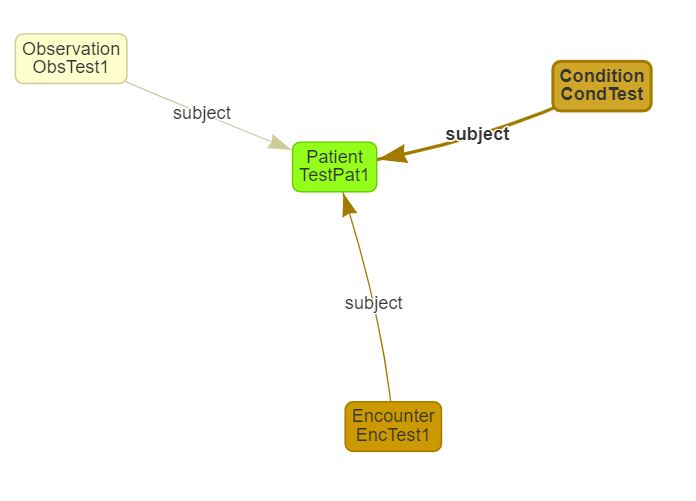